In [388]:
# import datetime
import math
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as image
from matplotlib.offsetbox import  OffsetImage

#matplotlib inline
import pyproj
import pymap3d as pm

from astropy.time import Time



In [408]:
stacode='dyng'
## input data
data = pd.read_csv("data/turkeq/{}_kin03709_11.cts".format(stacode), sep=" ")

#data["dates"]
data['Lat'], data['Lon'], data['Alt'] = pm.ecef2geodetic(data['X'], data['Y'], data['Z'], ell=None, deg=True)
#data['ddate'] = pd.to_datetime(data['dates'], format='%d/%m/%Y')
#data['date'] = pd.to_datetime(data.date + data.h.astype(str),format='%d/%m/%Y %H').dt.time
#data['date']
#data['time'] =data['h'].astype(str) +':'+ data['min'].astype(str)+':'+data['sec'].astype(str)
#data['date'] = pd.to_datetime(data['ddate'].astype(str) +' '+ data['time'].astype(str))
#data['jd'] = data['mjd'] + 2400000.5

data['mjdTim'] = data['mjd']+data['sod']/(3600*24)

data['Date'] = Time(data['mjdTim'], format='mjd').datetime

#P = pyproj.Proj(proj='utm', zone=34, ellps='WGS84', preserve_units=False)
#data['utmE'], data['utmN'] = P(data['Lon'], data['Lat'])

## set index
data = data.set_index(['Date'])
data
## convert and make index to dataframwe
#time_data = "3/4/2022 12:16:25.123"
#format_data = "%d/%m/%Y"
#date = datetime.strptime(data['dates'], format_data)
#data
header= ['X','Y','Z',]
#data.to_csv('test_p2.txt', columns=header)
#utmout = data[['utmE', 'utmN', 'Alt']].copy()
#
#utmout
#utmout.to_csv('Outputs/utm_ts.txt')
data

,mjd,sod,X,Y,Z,Lat,Lon,Alt,mjdTim
Date,,,,,,,,,
2023-02-06 09:00:04,59981,32404.0,4595220.077,2039434.233,3912625.903,38.078552,23.932435,510.602248,59981.375046
2023-02-06 09:00:05,59981,32405.0,4595220.078,2039434.234,3912625.902,38.078552,23.932435,510.602670,59981.375058
2023-02-06 09:00:06,59981,32406.0,4595220.083,2039434.235,3912625.903,38.078552,23.932435,510.607204,59981.375069
2023-02-06 09:00:07,59981,32407.0,4595220.079,2039434.234,3912625.902,38.078552,23.932435,510.603390,59981.375081
2023-02-06 09:00:08,59981,32408.0,4595220.077,2039434.233,3912625.901,38.078552,23.932435,510.601015,59981.375093
...,...,...,...,...,...,...,...,...,...
2023-02-06 11:14:55,59981,40495.0,4595220.040,2039434.229,3912625.857,38.078552,23.932435,510.545980,59981.468692
2023-02-06 11:14:56,59981,40496.0,4595220.039,2039434.230,3912625.858,38.078552,23.932435,510.546196,59981.468704
2023-02-06 11:14:57,59981,40497.0,4595220.044,2039434.236,3912625.862,38.078552,23.932436,510.554177,59981.468715


In [409]:
## convert to E N UP
meanX=data['X'].mean()
meanY=data['Y'].mean()
meanZ=data['Z'].mean()

ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
#mLon, mLat, mAlt = pyproj.transform(ecef, lla, meanX, meanY, meanZ, radians=False)
mLat, mLon, mAlt = pm.ecef2geodetic(meanX, meanY, meanZ,  ell=None, deg=True)


print(mLon, mLat, mAlt)

# mLon_r=math.radians(mLon)
# mLat_r=math.radians(mLat)
# print(meanLon, meanLat, meanAlt)

data['dX'] = data['X'] - meanX
data['dY'] = data['Y'] - meanY
data['dZ'] = data['Z'] - meanZ

## make rotational matrix
#R = [ 
#    [-math.sin(mLat_r)*math.cos(mLon_r), -math.sin(mLat_r)*math.sin(mLon_r), math.cos(mLat_r)],
#    [-math.sin(mLon_r), math.cos(mLon_r), 0],
#    [math.cos(mLat_r)*math.cos(mLon_r), math.cos(mLat_r)*math.sin(mLon_r), math.sin(mLat_r)]
#]


data['dE'], data['dN'], data['dU'] = pm.ecef2enu(data['X'], data['Y'], data['Z'], mLat, mLon, mAlt, ell=None, deg=True)
data['dN'] = data['dN']*1000.
data['dE'] = data['dE']*1000.
data['dU'] = data['dU']*1000.

#indexdN = data[ (data['dN'] >= 40) | (data['dN'] <=-40) ].index
#data.drop(indexdN , inplace=True)
header= ['X','Y','Z','dN', 'dE', 'dU']
data.to_csv('Outputs/230206_tur/smartnet/{}_enu.csv'.format(stacode), columns=header)
data

23.93243530858264 38.078551986544184 510.5644068852775


,mjd,sod,X,Y,Z,Lat,Lon,Alt,mjdTim,dX,dY,dZ,dE,dN,dU
Date,,,,,,,,,,,,,,,
2023-02-06 09:00:04,59981,32404.0,4595220.077,2039434.233,3912625.903,38.078552,23.932435,510.602248,59981.375046,0.026506,0.013406,0.023494,1.500837,0.198223,37.841466
2023-02-06 09:00:05,59981,32405.0,4595220.078,2039434.234,3912625.902,38.078552,23.932435,510.602670,59981.375058,0.027506,0.014406,0.022494,2.009202,-1.402846,38.263535
2023-02-06 09:00:06,59981,32406.0,4595220.083,2039434.235,3912625.903,38.078552,23.932435,510.607204,59981.375069,0.032506,0.015406,0.023494,0.894932,-3.684450,42.797042
2023-02-06 09:00:07,59981,32407.0,4595220.079,2039434.234,3912625.902,38.078552,23.932435,510.603390,59981.375081,0.028506,0.014406,0.022494,1.603543,-1.966563,38.983024
2023-02-06 09:00:08,59981,32408.0,4595220.077,2039434.233,3912625.901,38.078552,23.932435,510.601015,59981.375093,0.026506,0.013406,0.021494,1.500837,-1.376109,36.607984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-06 11:14:55,59981,40495.0,4595220.040,2039434.229,3912625.857,38.078552,23.932435,510.545980,59981.468692,-0.010494,0.009406,-0.022506,12.854125,-14.153150,-18.427005
2023-02-06 11:14:56,59981,40496.0,4595220.039,2039434.230,3912625.858,38.078552,23.932435,510.546196,59981.468704,-0.011494,0.010406,-0.021506,14.173809,-13.052454,-18.210432
2023-02-06 11:14:57,59981,40497.0,4595220.044,2039434.236,3912625.862,38.078552,23.932436,510.554177,59981.468715,-0.006494,0.016406,-0.017506,17.629660,-14.223493,-10.230096


In [410]:
# split dataframe into two for each earthquake

df1 = data.loc['2023-02-06 01:10:00' : '2023-02-06 01:40:00', :]

df1


df2 = data.loc['2023-02-06 10:20:00' : '2023-02-06 10:50:00', :]

df2

,mjd,sod,X,Y,Z,Lat,Lon,Alt,mjdTim,dX,dY,dZ,dE,dN,dU
Date,,,,,,,,,,,,,,,
2023-02-06 10:20:00,59981,37200.0,4595220.051,2039434.218,3912625.873,38.078552,23.932435,510.560250,59981.430556,0.000506,-0.001594,-0.006506,-1.662394,-5.007324,-4.157298
2023-02-06 10:20:01,59981,37201.0,4595220.048,2039434.219,3912625.871,38.078552,23.932435,510.557177,59981.430567,-0.002494,-0.000594,-0.008506,0.468608,-5.140693,-7.229926
2023-02-06 10:20:02,59981,37202.0,4595220.046,2039434.217,3912625.869,38.078552,23.932435,510.553866,59981.430579,-0.004494,-0.002594,-0.010506,-0.548123,-5.087218,-10.541029
2023-02-06 10:20:03,59981,37203.0,4595220.052,2039434.218,3912625.873,38.078552,23.932435,510.560969,59981.430590,0.001506,-0.001594,-0.006506,-2.068053,-5.571040,-3.437809
2023-02-06 10:20:04,59981,37204.0,4595220.045,2039434.217,3912625.870,38.078552,23.932435,510.553763,59981.430602,-0.005494,-0.002594,-0.009506,-0.142464,-3.736335,-10.643776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-06 10:49:56,59981,38996.0,4595220.037,2039434.213,3912625.862,38.078552,23.932435,510.541796,59981.451343,-0.013494,-0.006594,-0.017506,-0.553289,-4.523183,-22.610902
2023-02-06 10:49:57,59981,38997.0,4595220.036,2039434.211,3912625.861,38.078552,23.932435,510.539821,59981.451354,-0.014494,-0.008594,-0.018506,-1.975679,-4.246259,-24.585774
2023-02-06 10:49:58,59981,38998.0,4595220.039,2039434.213,3912625.860,38.078552,23.932435,510.542001,59981.451366,-0.011494,-0.006594,-0.019506,-1.364607,-7.224948,-22.405407


In [411]:
# rotate axes 1
from pyproj import Geod

lat_eq1 = 37.226
lon_eq1 = 37.014



lat1 = df1['Lat'][0]
lon1 = df1['Lon'][0]



#azimuth
g = Geod(ellps='WGS84') 
a1 = g.inv(lon_eq1, lat_eq1, -lon1, lat1)[0]
a1=math.radians(a1)

#print(a1)
   
if a1<0:
        a1=abs(a1)
        a1=2*np.pi-a1
        

        
print(a1)

       
R1 = np.array([[math.cos(a1), -(math.sin(a1))],
                [(math.sin(a1)), math.cos(a1)]])
    
xy1 = df1[['dE', 'dN']].to_numpy()
uv1 = []
for item in xy1:
    uv1.append(R1.dot(item.T))
#print(uv)
uv1 = (np.array(uv1)).T
    
df1['U'] = uv1[0]
df1['V'] = uv1[1]

df1

IndexError: index 0 is out of bounds for axis 0 with size 0

In [412]:
#rotate axis 2

lat_eq2 = 38.011
lon_eq2 = 37.196

lat2 = df2['Lat'][0]
lon2 = df2['Lon'][0]

if a2<0:
        a2=abs(a2)
        a2=2*np.pi-a2
        
print(a2)

a2 = g.inv(lon_eq2, lat_eq2, -lon2, lat2)[0]
a2=math.radians(a2)

R2 = np.array([[math.cos(a2), -(math.sin(a2))],
                [(math.sin(a2)), math.cos(a2)]])

xy2 = df2[['dE', 'dN']].to_numpy()
uv2 = []
for item in xy2:
    uv2.append(R2.dot(item.T))
#print(uv)
uv2 = (np.array(uv2)).T
    
df2['U'] = uv2[0]
df2['V'] = uv2[1]

df2

5.036529057435213


<ipython-input-412-bb8548dfa01d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['U'] = uv2[0]
<ipython-input-412-bb8548dfa01d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['V'] = uv2[1]


,mjd,sod,X,Y,Z,Lat,Lon,Alt,mjdTim,dX,dY,dZ,dE,dN,dU,U,V
Date,,,,,,,,,,,,,,,,,
2023-02-06 10:20:00,59981,37200.0,4595220.051,2039434.218,3912625.873,38.078552,23.932435,510.560250,59981.430556,0.000506,-0.001594,-0.006506,-1.662394,-5.007324,-4.157298,-5.273713,-0.157444
2023-02-06 10:20:01,59981,37201.0,4595220.048,2039434.219,3912625.871,38.078552,23.932435,510.557177,59981.430567,-0.002494,-0.000594,-0.008506,0.468608,-5.140693,-7.229926,-4.667485,-2.204745
2023-02-06 10:20:02,59981,37202.0,4595220.046,2039434.217,3912625.869,38.078552,23.932435,510.553866,59981.430579,-0.004494,-0.002594,-0.010506,-0.548123,-5.087218,-10.541029,-4.966265,-1.231436
2023-02-06 10:20:03,59981,37203.0,4595220.052,2039434.218,3912625.873,38.078552,23.932435,510.560969,59981.430590,0.001506,-0.001594,-0.006506,-2.068053,-5.571040,-3.437809,-5.942426,0.030064
2023-02-06 10:20:04,59981,37204.0,4595220.045,2039434.217,3912625.870,38.078552,23.932435,510.553763,59981.430602,-0.005494,-0.002594,-0.009506,-0.142464,-3.736335,-10.643776,-3.558215,-1.148738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-06 10:49:56,59981,38996.0,4595220.037,2039434.213,3912625.862,38.078552,23.932435,510.541796,59981.451343,-0.013494,-0.006594,-0.017506,-0.553289,-4.523183,-22.610902,-4.438275,-1.032971
2023-02-06 10:49:57,59981,38997.0,4595220.036,2039434.211,3912625.861,38.078552,23.932435,510.539821,59981.451354,-0.014494,-0.008594,-0.018506,-1.975679,-4.246259,-24.585774,-4.666431,0.398051
2023-02-06 10:49:58,59981,38998.0,4595220.039,2039434.213,3912625.860,38.078552,23.932435,510.542001,59981.451366,-0.011494,-0.006594,-0.019506,-1.364607,-7.224948,-22.405407,-7.254375,-1.198366


In [406]:
#calculate max displacements earthquake 1

#max_dN_1 = df1['dN'].abs().max()
#print(max_dN_1, end=' ')
#print(df1.index[df1["dN"]==max_dN_1].tolist())
#print(df1[df1['dN'] == max_dN_1].index.values[0], end=' ')
#print(df1[df1['dN'] == max_dN_1].index.strftime('%m/%d/%Y, %r'))


#print(t_dN1,end=' ')
#f1.index = pd.to_datetime(df1[df1['dN'] == max_dN_1].index.values)
    
#max_dE_1 = df1['dE'].abs().max()
#print(max_dE_1,end=' ')
#print(df1[df1['dE'] == max_dE_1].index.values,end=' ')

#max_U_1 = df1['U'].abs().max()
#print(max_U_1,end=' ')
#print(df1[df1['U'] == max_U_1].index.values[0],end=' ')

#max_V_1 = df1['V'].abs().max()
#print(max_V_1,end=' ')
#print(df1[df1['V'] == max_V_1].index.values[0])

line = '{} '.format(stacode)
for c in ['dN', 'dE', 'U', 'V']:
    max_c = df1[c].max()
    max_t = df1[df1[c] == max_c].index.values[0]
    #max_t = max_t[0] if len(max_t)>0 else None
    #print('max {:} epoch: {:}'.format(max_c, max_t))
    line += '{:} {:} '.format(max_c, max_t)
print(line)

## output file format: code dn time de time U time V time
#fout =  open('Outputs/output_eq1.txt','a')
with open("Outputs/output_eq1.txt", "a") as fout:
    fout.write("{:} \n".format(line))
fout.close()


dyng 9.077602981534191 2023-02-06T01:24:29.000000000 17.46867779684824 2023-02-06T01:25:21.000000000 8.276288608390994 2023-02-06T01:24:29.000000000 7.2295593089854275 2023-02-06T01:23:45.000000000 


In [413]:
#calculate max displacements earthquake 2

#max_dN_2 = df2['dN'].abs().max()
#print(max_dN_2)
#print(df2[df2['dN'] == max_dN_2].index.values)
    
#max_dE_2 = df2['dE'].abs().max()
#print(max_dE_2)
#print(df2[df2['dE'] == max_dE_2].index.values)

#max_U_2 = df2['U'].abs().max()
#print(max_U_2)
#print(df2[df2['U'] == max_U_2].index.values)

#max_V_2 = df2['V'].abs().max()
#print(max_V_2)
#print(df2[df2['V'] == max_V_2].index.values)

line = '{} '.format(stacode)
for c in ['dN', 'dE', 'U', 'V']:
    max_c = df2[c].max()
    max_t = df2[df2[c] == max_c].index.values[0]
    #max_t = max_t[0] if len(max_t)>0 else None
    #print('max {:} epoch: {:}'.format(max_c, max_t))
    line += '{:} {:} '.format(max_c, max_t)
print(line)

## output file format: code dn time de time U time V time
#fout =  open('Outputs/output_eq1.txt','a')
with open("Outputs/output_eq2.txt", "a") as fout:
    fout.write("{:} \n".format(line))
fout.close()


dyng 24.315164401152273 2023-02-06T10:31:21.000000000 22.194616129202668 2023-02-06T10:32:07.000000000 22.02033241189227 2023-02-06T10:31:21.000000000 15.774208895338719 2023-02-06T10:31:58.000000000 


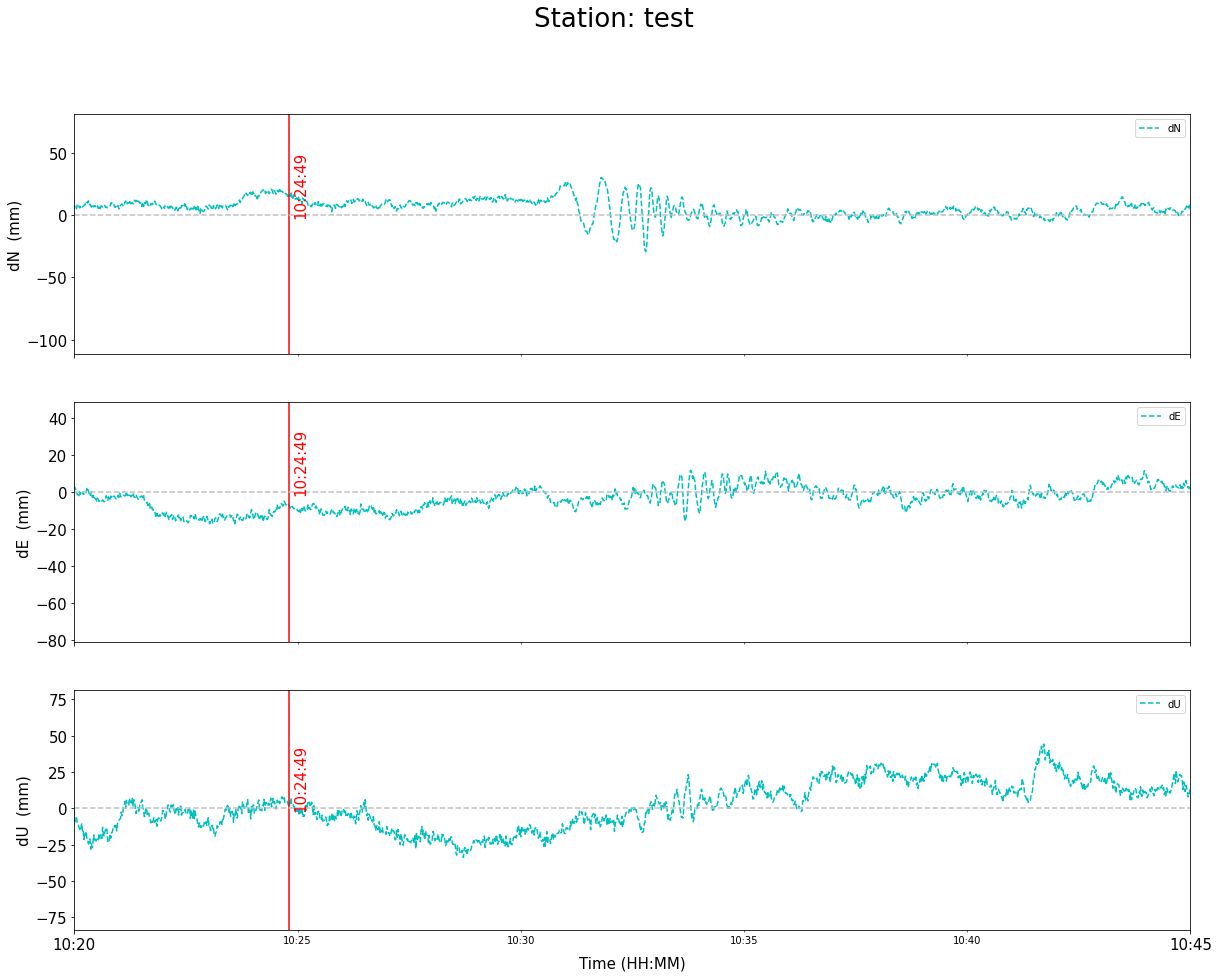

In [395]:
## make time series for the three axes
fig, axes = plt.subplots(3, 1, figsize=(20,15), sharex=True,)
fig.suptitle('Station: test', fontsize=26)


plot_cols = ['dN', 'dE', 'dU' ]
#plot_cols = ['dX', 'dY', 'dZ' ]

data[plot_cols].plot(subplots=True, ax=axes, linestyle='--', marker='', color='c')

#month_day_formatter = mdates.DateFormatter("%Y-%m-%d")
month_day_formatter = mdates.DateFormatter("%H:%M:%S")

ylimits = [[-30,30],[-20,20],[-30,30]]
#ylimits = [[-70,70],[-70,70],[-60,60]]

for i, (ax, col) in enumerate(zip(axes, plot_cols)):
    # add axis labels
    ax.set_ylabel(col + '  (mm)',fontsize=15)
    ax.set_xlabel('Time (HH:MM)', fontsize=15)
#    ax.xaxis.set_major_formatter(month_day_formatter)
#    ax.set_xlim([pd.Timestamp('2023-02-06 01:15:00'), pd.Timestamp('2023-02-06 01:35:00')])
    ax.set_xlim([pd.Timestamp('2023-02-06 10:20:00'), pd.Timestamp('2023-02-06 10:45:00')])
    #ax.set_ylim([-30,30])
#    ax.set_ylim(ylimits[i])
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=15)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
##EVIA PERIVOLIA
    #ax.axvline(pd.Timestamp('2022-11-29 04:32:36'),color='r')
    #ax.axvline(pd.Timestamp('2022-11-29 20:06:39'),color='r')
##EVIA PSAXNA - XALKIDA
    ax.axvline(pd.Timestamp('2023-02-06 01:17:36'), color='r')
    ax.axvline(pd.Timestamp('2023-02-06 10:24:49'), color='r')
#    ax.text(pd.Timestamp('2023-02-06 01:17:40'), 0, '01:17:36', size=15, color='r', rotation=90)
    ax.text(pd.Timestamp('2023-02-06 10:24:55'), 0, '10:24:49', size=15, color='r', rotation=90)
    ax.axhline(y=0, linestyle='--', color='silver')
#    ax.axhline(y=-160, linestyle='--', color='mistyrose')
#    ax.axhline(y=120, linestyle='--', color='mistyrose')
##########0117
#    ax.axvspan(pd.Timestamp('2023-02-06 01:20:30'), pd.Timestamp('2023-02-06 01:22:50'), alpha=0.1, color='r') #ARUC
#    ax.axvspan(pd.Timestamp('2023-02-06 01:20:30'), pd.Timestamp('2023-02-06 01:22:50'), alpha=0.1, color='r') #BSHM
#    ax.axvspan(pd.Timestamp('2023-02-06 01:19:50'), pd.Timestamp('2023-02-06 01:25:20'), alpha=0.1, color='r') #NICO
#    ax.axvspan(pd.Timestamp('2023-02-06 01:23:30'), pd.Timestamp('2023-02-06 01:25:40'), alpha=0.1, color='r') #DYNG
##########1024
#    ax.axvspan(pd.Timestamp('2023-02-06 10:27:50'), pd.Timestamp('2023-02-06 10:29:30'), alpha=0.1, color='r') #ARUC
#    ax.axvspan(pd.Timestamp('2023-02-06 10:27:30'), pd.Timestamp('2023-02-06 10:29:30'), alpha=0.1, color='r') #BSHM
#    ax.axvspan(pd.Timestamp('2023-02-06 10:29:37'), pd.Timestamp('2023-02-06 10:31:00'), alpha=0.1, color='r') #NICO
#    ax.axvspan(pd.Timestamp('2023-02-06 10:26:10'), pd.Timestamp('2023-02-06 10:32:40'), alpha=0.1, color='r') #DYNG


In [396]:
## ADD LOGO+SAVE IMAGE
logo=image.imread("./logo/dso_ww_en.png")
addLogo = OffsetImage(logo, zoom=0.4)
#addLogo.set_zorder(100)
addLogo.set_offset((200,1000)) # pass the position in a tuple
ax.add_artist(addLogo)
#height = [0, 0, 0, 0, 0]
#bars = ('A', 'B', 'C', 'D', 'E')
#y = np.arange(len(bars))
#plt.bar(y, height, color=(0.2, 0.4, 0.6, 0.6))
## Save the figure
## =================================================================================
fig.savefig("Outputs/230206_tur/TEST_20230371024.jpg")
## =================================================================================

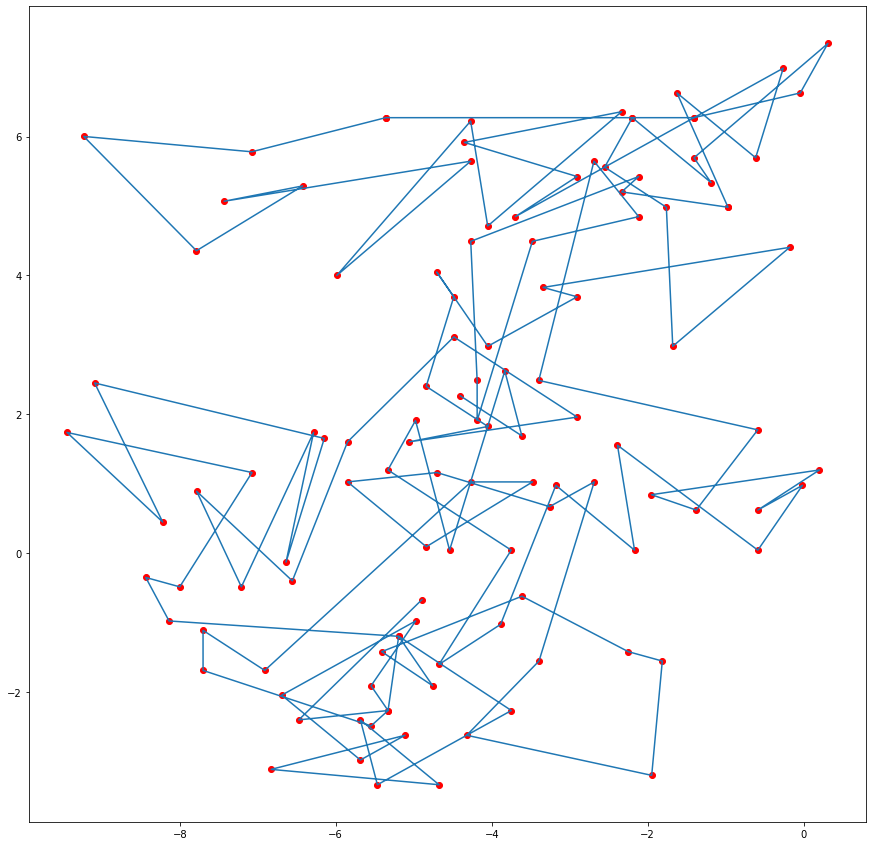

In [397]:
fig, ax = plt.subplots(figsize=(15,15))
DN=data.loc[(data.index > '2023-02-06 01:18:00') & (data.index < '2023-02-06 01:20:00'), 'dN']
DE=data.loc[(data.index > '2023-02-06 01:18:00') & (data.index < '2023-02-06 01:20:00'), 'dE']
ax.scatter(DN, DE, marker='o',linestyle='-', color='r') 
ax.plot(DN, DE, marker='',linestyle='-') 

In [398]:
#from hhpy.plotting import animplot

#animplot(data=data, x='dE', y='dN', t='sod', t_format='%S')

In [399]:
#anim.save('Outputs/230206_tur/animation.gif', writer='imagemagick', fps=60)

#data.index